[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10
Train Loss: 3.0670, Train Accuracy: 0.1271
Val Loss: 2.7962, Val Accuracy: 0.2750
Epoch 2/10
Train Loss: 2.4774, Train Accuracy: 0.4469
Val Loss: 2.0672, Val Accuracy: 0.6292
Epoch 3/10
Train Loss: 1.7849, Train Accuracy: 0.7281
Val Loss: 1.4039, Val Accuracy: 0.8167
Epoch 4/10
Train Loss: 1.1519, Train Accuracy: 0.9052
Val Loss: 0.9188, Val Accuracy: 0.9042
Epoch 5/10
Train Loss: 0.6693, Train Accuracy: 0.9771
Val Loss: 0.5339, Val Accuracy: 0.9333
Epoch 6/10
Train Loss: 0.3494, Train Accuracy: 0.9865
Val Loss: 0.2937, Val Accuracy: 0.9667
Epoch 7/10
Train Loss: 0.1665, Train Accuracy: 0.9969
Val Loss: 0.1810, Val Accuracy: 0.9667
Epoch 8/10
Train Loss: 0.0745, Train Accuracy: 1.0000
Val Loss: 0.1416, Val Accuracy: 0.9667
Epoch 9/10
Train Loss: 0.0392, Train Accuracy: 1.0000
Val Loss: 0.1097, Val Accuracy: 0.9708
Epoch 10/10
Train Loss: 0.0265, Train Accuracy: 1.0000
Val Loss: 0.1102, Val Accuracy: 0.9750


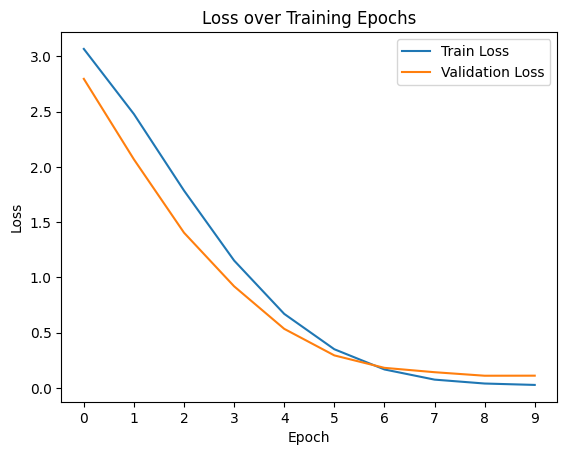

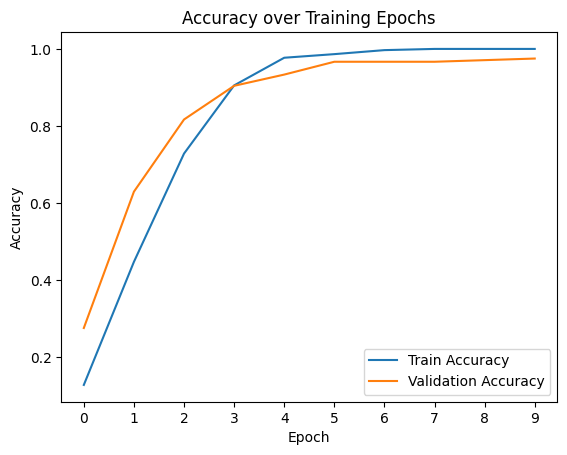

                                 precision    recall  f1-score   support

                           Acne       1.00      1.00      1.00        10
                      Arthritis       1.00      1.00      1.00        10
               Bronchial Asthma       1.00      1.00      1.00        10
           Cervical spondylosis       1.00      1.00      1.00        10
                    Chicken pox       1.00      0.90      0.95        10
                    Common Cold       1.00      0.90      0.95        10
                         Dengue       1.00      1.00      1.00        10
          Dimorphic Hemorrhoids       1.00      1.00      1.00        10
               Fungal infection       1.00      1.00      1.00        10
                   Hypertension       1.00      1.00      1.00        10
                       Impetigo       1.00      1.00      1.00        10
                       Jaundice       1.00      1.00      1.00        10
                        Malaria       0.91      1.

In [8]:
# Install required packages
!pip install transformers torch scikit-learn matplotlib nltk

import torch
import torch.nn as nn
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import DataLoader, TensorDataset, random_split
from torch.optim import AdamW
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string

# Initialize NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')
# Define constants
MAX_LEN = 128
BATCH_SIZE = 16
EPOCHS = 10
LEARNING_RATE = 2e-5
CLIP_VALUE = 1.0

# Load dataset
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Moayad/Symptom2Disease.csv")
df.drop("Unnamed: 0", axis=1, inplace=True)

# Preprocessing
stop_words = set(stopwords.words('english'))

def clean_text(sent):
    sent = sent.translate(str.maketrans('', '', string.punctuation)).strip()
    words = word_tokenize(sent)
    words = [word.lower() for word in words if word not in stop_words]
    return " ".join(words)

df["text"] = df["text"].apply(clean_text)

# Encode labels
label_encoder = LabelEncoder()
df["label"] = label_encoder.fit_transform(df["label"])
num_classes = len(label_encoder.classes_)

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    df["text"], df["label"], test_size=0.2, random_state=42, stratify=df["label"]
)

# Tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def tokenize_data(sentences, labels, max_len=MAX_LEN):
    inputs = tokenizer(list(sentences), max_length=max_len, padding=True, truncation=True, return_tensors="pt")
    return inputs['input_ids'], inputs['attention_mask'], torch.tensor(labels)

# Tokenize datasets
train_inputs, train_masks, train_labels = tokenize_data(X_train.tolist(), y_train.tolist())
test_inputs, test_masks, test_labels = tokenize_data(X_test.tolist(), y_test.tolist())

# Create DataLoader
train_dataset = TensorDataset(train_inputs, train_masks, train_labels)
test_dataset = TensorDataset(test_inputs, test_masks, test_labels)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

# Compute class weights for imbalance handling
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = torch.tensor(class_weights, dtype=torch.float).to('cuda' if torch.cuda.is_available() else 'cpu')

# Load model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels=num_classes,
    ignore_mismatched_sizes=True
)
model.to(device)

# Optimizer
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)

# Loss function with class weights
criterion = nn.CrossEntropyLoss(weight=class_weights)

# Training function
def train_model():
    history = {'loss': [], 'val_loss': [], 'accuracy': [], 'val_accuracy': []}
    for epoch in range(EPOCHS):
        model.train()
        total_loss, correct_preds = 0, 0

        for batch in train_loader:
            batch_inputs, batch_masks, batch_labels = [b.to(device) for b in batch]
            optimizer.zero_grad()
            outputs = model(batch_inputs, attention_mask=batch_masks, labels=batch_labels)
            loss = criterion(outputs.logits, batch_labels)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), CLIP_VALUE)
            optimizer.step()

            total_loss += loss.item()
            correct_preds += (torch.argmax(outputs.logits, axis=1) == batch_labels).sum().item()

        train_loss = total_loss / len(train_loader)
        train_acc = correct_preds / len(train_dataset)

        model.eval()
        val_loss, val_correct_preds = 0, 0
        with torch.no_grad():
            for batch in test_loader:
                batch_inputs, batch_masks, batch_labels = [b.to(device) for b in batch]
                outputs = model(batch_inputs, attention_mask=batch_masks, labels=batch_labels)
                loss = criterion(outputs.logits, batch_labels)
                val_loss += loss.item()
                val_correct_preds += (torch.argmax(outputs.logits, axis=1) == batch_labels).sum().item()

        val_loss /= len(test_loader)
        val_acc = val_correct_preds / len(test_dataset)

        history['loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['accuracy'].append(train_acc)
        history['val_accuracy'].append(val_acc)

        print(f"Epoch {epoch+1}/{EPOCHS}")
        print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}")
        print(f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.4f}")

    return history

# Train model
history = train_model()

# Plot training history
ax = plt.figure().gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.plot(history['loss'], label='Train Loss')
ax.plot(history['val_loss'], label='Validation Loss')
plt.title('Loss over Training Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

ax = plt.figure().gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.plot(history['accuracy'], label='Train Accuracy')
ax.plot(history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Training Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Evaluate model
model.eval()
predictions, true_labels = [], []

with torch.no_grad():
    for batch in test_loader:
        batch_inputs, batch_masks, batch_labels = [b.to(device) for b in batch]
        outputs = model(batch_inputs, attention_mask=batch_masks)
        predictions.extend(torch.argmax(outputs.logits, axis=1).cpu().numpy())
        true_labels.extend(batch_labels.cpu().numpy())

# Classification report
print(classification_report(true_labels, predictions, target_names=label_encoder.classes_, zero_division=0))
print(f"Accuracy: {accuracy_score(true_labels, predictions):.4f}")
